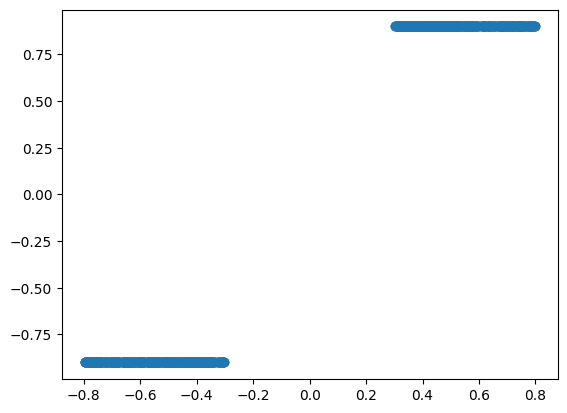

In [30]:
import stanza.runtime
stanza.runtime.setup() # setup logging, etc.

import jax
import jax.flatten_util
import matplotlib.pyplot as plt
import jax.numpy as jnp

from stanza.data import PyTreeData
from stanza.diffusion import DDPMSchedule

# Generate some data
data = "spaces"
if data == "cosine":
    def generate(rng_key: jax.Array) -> jax.Array:
        t = jax.random.uniform(rng_key, (), minval=-1, maxval=1)
        x = jnp.cos(10*t)
        return t, x
elif data == "spaces":
    space = 0.3
    diff = 0.9
    def generate(rng_key: jax.Array) -> jax.Array:
        t = jax.random.uniform(rng_key, (), minval=-1, maxval=1)
        t = (0.8-space)*t + space*jnp.sign(t)
        x = diff * jnp.sign(t)
        return t, x

train_data = jax.vmap(generate)(jax.random.split(jax.random.PRNGKey(42), 1024))
train_data = PyTreeData(train_data)
test_data = jax.vmap(generate)(jax.random.split(jax.random.PRNGKey(43), 1024))
test_data = PyTreeData(test_data)

schedule = DDPMSchedule.make_squaredcos_cap_v2(10, prediction_type="sample")

plt.scatter(train_data.tree[0], train_data.tree[1])
plt.show()

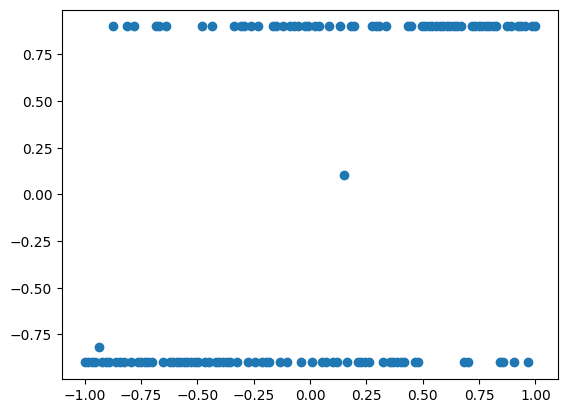

In [31]:
from functools import partial
# # The schedule also has the compute_denoised method
# # which given a (small) dataset will compute the ground-truth model output!
# # This is useful for debugging whether the denoiser has sufficient
# # capacity to capture the true score function.
def gt_denoiser(cond_traj, rng_key, x, t):
    # noise the conditioning variable
    cond = cond_traj[t]
    _, denoised_x = schedule.compute_denoised((cond, x), t, train_data.tree)
    return schedule.output_from_denoised(x, t, denoised_x)

@jax.jit
def sample_gt(rng_key, cond):
    cond_traj, _ = schedule.forward_trajectory(rng_key, cond)
    return cond, schedule.sample(rng_key, partial(gt_denoiser, cond_traj), train_data[0][1])

gt_samples = jax.vmap(sample_gt)(jax.random.split(jax.random.PRNGKey(42), 128), jnp.linspace(-1, 1, 128))
plt.clf()
plt.scatter(gt_samples[0], gt_samples[1])
plt.show()